<a href="https://colab.research.google.com/github/ast-abo/ShotTracker/blob/Export-Model/ShotTrackerModelTraingScript.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import sys

drive.mount('/content/gdrive')
sys.path.append('/content/gdrive/My Drive/Colab Notebooks')

Mounted at /content/gdrive


In [ ]:
nb_path = '/content/notebooks'
sys.path.insert(0, nb_path)  # or append(nb_path)
#The last three lines are what changes the path of the file.
!pip install --target=$nb_path


In [ ]:
from roboflow import Roboflow
import os
import ultralytics
HOME = os.getcwd()
print(HOME)
ultralytics.checks()

Ultralytics 8.3.40 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 37.1/107.7 GB disk)


In [ ]:
import os
import shutil

!yolo task=detect mode=predict model=yolo11n.pt conf=0.25 source='https://hc-cdn.hel1.your-objectstorage.com/s/v3/9b5aca918f91e5abfa21b0457b0022116ff32412_photo-1629901925121-8a141c2a42f4.jpeg' save=True

# Define paths
OutputDirectory = "runs/detect/predict"
OldFileName = "9b5aca918f91e5abfa21b0457b0022116ff32412_photo-1629901925121-8a141c2a42f4.jpg"  # The original file name
NewFileName = "ball.jpg"  # The desired new name

# Rename the file
OldFilePath = os.path.join(OutputDirectory, OldFileName)
NewFilePath = os.path.join(OutputDirectory, NewFileName)
print(OldFilePath)


try:
    shutil.move(OldFilePath, NewFilePath)
    print(f"File renamed to {NewFilePath}")
except Exception as e:
    print(f"Error renaming file: {e}")

/bin/bash: line 1: yolo: command not found
runs/detect/predict/9b5aca918f91e5abfa21b0457b0022116ff32412_photo-1629901925121-8a141c2a42f4.jpg
Error renaming file: [Errno 2] No such file or directory: 'runs/detect/predict/9b5aca918f91e5abfa21b0457b0022116ff32412_photo-1629901925121-8a141c2a42f4.jpg'


In [ ]:
from ultralytics import YOLO
from PIL import Image
import requests

model = YOLO('yolo11n.pt')
image = Image.open(requests.get('https://hc-cdn.hel1.your-objectstorage.com/s/v3/9b5aca918f91e5abfa21b0457b0022116ff32412_photo-1629901925121-8a141c2a42f4.jpeg', stream=True).raw)
result = model.predict(image, conf=0.25)[0]

100%|██████████| 5.35M/5.35M [00:00<00:00, 113MB/s]



0: 640x448 1 person, 1 clock, 427.1ms
Speed: 37.2ms preprocess, 427.1ms inference, 36.3ms postprocess per image at shape (1, 3, 640, 448)


In [ ]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets

rf = Roboflow(api_key="NLWnQPigGaE8pl98gFYh")
project = rf.workspace("icespace").project("basketballandhoop-ahbj5-wjfgv")
version = project.version(1)
dataset = version.download("yolov11")

/content/datasets
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Shot-Tracker-2 in yolov11:: 100%|██████████| 52/52 [00:00<00:00, 5669.89it/s]


In [ ]:
%cd {HOME}

results = model.train(data="/content/datasets/Shot-Tracker-2/data.yaml", epochs=100, imgsz=640, optimizer='adam', patience=25)

New https://pypi.org/project/ultralytics/8.3.121 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.40 🚀 Python-3.11.12 torch-2.6.0+cpu CPU (Intel Xeon 2.00GHz)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/content/datasets/BasketballAndHoop-1/data.yaml, epochs=100, time=None, patience=25, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=F

100%|██████████| 755k/755k [00:00<00:00, 14.0MB/s]


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /content/datasets/BasketballAndHoop-1/train/labels... 613 images, 0 backgrounds, 0 corrupt: 100%|██████████| 613/613 [00:00<00:00, 1614.24it/s]

train: New cache created: /content/datasets/BasketballAndHoop-1/train/labels.cache
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 3, len(boxes) = 971. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.



val: Scanning /content/datasets/BasketballAndHoop-1/valid/labels... 112 images, 0 backgrounds, 0 corrupt: 100%|██████████| 112/112 [00:00<00:00, 1567.78it/s]

val: New cache created: /content/datasets/BasketballAndHoop-1/valid/labels.cache


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: Adam(lr=0.01, momentum=0.937) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train2
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100         0G      1.974      2.884      1.748         20        640: 100%|██████████| 39/39 [02:15<00:00,  3.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:08<00:00,  2.20s/it]

                   all        112        187    0.00112      0.088    0.00735    0.00188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100         0G      1.697      1.893      1.513         12        640: 100%|██████████| 39/39 [02:11<00:00,  3.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:09<00:00,  2.41s/it]

                   all        112        187      0.429      0.439      0.277       0.15



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100         0G      1.766       1.88      1.587         11        640: 100%|██████████| 39/39 [02:10<00:00,  3.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:09<00:00,  2.33s/it]

                   all        112        187      0.552     0.0298      0.059     0.0264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100         0G      1.655      1.819      1.498         15        640: 100%|██████████| 39/39 [02:11<00:00,  3.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:08<00:00,  2.07s/it]

                   all        112        187      0.369      0.449      0.363      0.186



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100         0G      1.564      1.673      1.484         12        640: 100%|██████████| 39/39 [02:12<00:00,  3.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:09<00:00,  2.27s/it]

                   all        112        187       0.52      0.556      0.539      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100         0G      1.511      1.563      1.418          7        640: 100%|██████████| 39/39 [02:12<00:00,  3.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:07<00:00,  1.98s/it]

                   all        112        187      0.448      0.461      0.452      0.231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100         0G      1.483      1.512      1.398          9        640: 100%|██████████| 39/39 [02:14<00:00,  3.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:08<00:00,  2.05s/it]

                   all        112        187      0.588      0.573      0.598      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100         0G      1.447      1.413      1.367         13        640: 100%|██████████| 39/39 [02:15<00:00,  3.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:09<00:00,  2.40s/it]

                   all        112        187      0.639      0.617      0.638      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100         0G      1.374      1.369      1.333         21        640: 100%|██████████| 39/39 [02:11<00:00,  3.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:08<00:00,  2.14s/it]

                   all        112        187       0.68      0.663      0.701       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100         0G      1.361       1.35      1.332         10        640: 100%|██████████| 39/39 [02:12<00:00,  3.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:07<00:00,  1.93s/it]

                   all        112        187       0.66      0.606      0.651      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100         0G      1.388      1.323      1.346         11        640: 100%|██████████| 39/39 [02:12<00:00,  3.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:07<00:00,  1.95s/it]

                   all        112        187      0.646      0.693      0.674      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100         0G      1.368      1.296       1.31         16        640: 100%|██████████| 39/39 [02:13<00:00,  3.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:08<00:00,  2.20s/it]

                   all        112        187      0.664      0.672      0.685      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100         0G      1.349      1.241      1.297         13        640: 100%|██████████| 39/39 [02:12<00:00,  3.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:07<00:00,  1.95s/it]

                   all        112        187      0.646      0.707      0.659      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100         0G      1.288      1.188      1.252         10        640: 100%|██████████| 39/39 [02:10<00:00,  3.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:09<00:00,  2.28s/it]

                   all        112        187      0.857      0.673      0.767      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100         0G      1.315      1.195      1.264          9        640: 100%|██████████| 39/39 [02:12<00:00,  3.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:08<00:00,  2.17s/it]

                   all        112        187      0.746        0.7      0.723      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100         0G      1.265      1.149      1.221         14        640: 100%|██████████| 39/39 [02:11<00:00,  3.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:09<00:00,  2.44s/it]

                   all        112        187      0.718      0.657      0.711      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100         0G      1.256      1.124      1.249         13        640: 100%|██████████| 39/39 [02:13<00:00,  3.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:08<00:00,  2.05s/it]

                   all        112        187      0.672      0.656      0.639       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100         0G      1.224      1.092      1.223          9        640: 100%|██████████| 39/39 [02:12<00:00,  3.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:08<00:00,  2.20s/it]

                   all        112        187      0.803       0.66      0.722       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100         0G      1.229      1.071      1.217          6        640: 100%|██████████| 39/39 [02:12<00:00,  3.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:07<00:00,  1.98s/it]

                   all        112        187      0.724       0.69       0.71      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100         0G      1.212      1.045      1.211         10        640: 100%|██████████| 39/39 [02:13<00:00,  3.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:08<00:00,  2.10s/it]

                   all        112        187      0.689      0.749      0.697      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100         0G      1.243      1.064      1.234         15        640: 100%|██████████| 39/39 [02:10<00:00,  3.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:08<00:00,  2.11s/it]

                   all        112        187      0.754      0.703      0.723      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100         0G      1.192      1.014      1.228          8        640: 100%|██████████| 39/39 [02:11<00:00,  3.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:08<00:00,  2.03s/it]

                   all        112        187      0.771      0.703      0.728      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100         0G      1.201      1.039      1.208         13        640: 100%|██████████| 39/39 [02:09<00:00,  3.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:08<00:00,  2.07s/it]

                   all        112        187      0.794      0.685      0.731      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100         0G      1.157     0.9922      1.195         20        640: 100%|██████████| 39/39 [02:09<00:00,  3.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:09<00:00,  2.38s/it]

                   all        112        187      0.747      0.653      0.707      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100         0G      1.113     0.9512      1.177         13        640: 100%|██████████| 39/39 [02:12<00:00,  3.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:09<00:00,  2.33s/it]

                   all        112        187      0.719      0.736      0.732      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100         0G      1.137     0.9453      1.157         17        640: 100%|██████████| 39/39 [02:13<00:00,  3.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:07<00:00,  1.95s/it]

                   all        112        187      0.714      0.755      0.762       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100         0G      1.112      0.902      1.166          8        640: 100%|██████████| 39/39 [02:12<00:00,  3.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:08<00:00,  2.10s/it]

                   all        112        187      0.737      0.731      0.752      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100         0G      1.115     0.9424      1.168         18        640: 100%|██████████| 39/39 [02:13<00:00,  3.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:09<00:00,  2.45s/it]

                   all        112        187      0.735      0.691      0.701      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100         0G      1.109     0.9335      1.165         13        640: 100%|██████████| 39/39 [02:17<00:00,  3.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:08<00:00,  2.00s/it]

                   all        112        187      0.738      0.704      0.738      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100         0G      1.111     0.9281      1.158          8        640: 100%|██████████| 39/39 [02:14<00:00,  3.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:07<00:00,  2.00s/it]

                   all        112        187      0.814      0.708      0.779      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100         0G       1.09     0.9173      1.152          7        640: 100%|██████████| 39/39 [02:13<00:00,  3.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:08<00:00,  2.15s/it]

                   all        112        187      0.758      0.724       0.72      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100         0G       1.09     0.8883      1.169         11        640: 100%|██████████| 39/39 [02:13<00:00,  3.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:07<00:00,  1.93s/it]

                   all        112        187      0.799      0.728      0.782      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100         0G      1.047     0.8677      1.127         19        640: 100%|██████████| 39/39 [02:12<00:00,  3.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:08<00:00,  2.21s/it]

                   all        112        187      0.778      0.752      0.772      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100         0G      1.078     0.8858      1.139         11        640: 100%|██████████| 39/39 [02:09<00:00,  3.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:08<00:00,  2.15s/it]

                   all        112        187      0.763      0.646      0.702      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100         0G      1.085     0.8619      1.159         11        640: 100%|██████████| 39/39 [02:11<00:00,  3.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:07<00:00,  1.90s/it]

                   all        112        187      0.744      0.752      0.736      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100         0G      1.034     0.8425      1.124         17        640: 100%|██████████| 39/39 [02:11<00:00,  3.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:09<00:00,  2.41s/it]

                   all        112        187      0.788      0.745      0.784      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100         0G       1.03     0.8452      1.127          8        640: 100%|██████████| 39/39 [02:11<00:00,  3.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:07<00:00,  1.90s/it]

                   all        112        187      0.716      0.737      0.728      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100         0G      1.023     0.8246      1.132          9        640: 100%|██████████| 39/39 [02:10<00:00,  3.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:07<00:00,  1.90s/it]

                   all        112        187      0.782      0.782      0.789       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100         0G      1.062     0.8525      1.133         14        640: 100%|██████████| 39/39 [02:12<00:00,  3.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:08<00:00,  2.15s/it]

                   all        112        187      0.814      0.702      0.742      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100         0G          1     0.7817      1.093         19        640: 100%|██████████| 39/39 [02:14<00:00,  3.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:08<00:00,  2.16s/it]

                   all        112        187      0.771      0.745      0.759      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100         0G     0.9813     0.7673      1.081         12        640: 100%|██████████| 39/39 [02:10<00:00,  3.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:08<00:00,  2.03s/it]

                   all        112        187      0.785      0.746      0.753      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100         0G      1.003     0.7763      1.106         12        640: 100%|██████████| 39/39 [02:08<00:00,  3.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:07<00:00,  1.88s/it]

                   all        112        187      0.778      0.757      0.774      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100         0G     0.9909     0.7784      1.101         12        640: 100%|██████████| 39/39 [02:11<00:00,  3.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:07<00:00,  1.90s/it]

                   all        112        187      0.746      0.792      0.762      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100         0G      1.018     0.7992      1.105         10        640: 100%|██████████| 39/39 [02:11<00:00,  3.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:07<00:00,  2.00s/it]

                   all        112        187      0.736      0.795      0.762      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100         0G      1.017     0.7762      1.112          9        640: 100%|██████████| 39/39 [02:11<00:00,  3.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:07<00:00,  1.93s/it]

                   all        112        187      0.746      0.776      0.753      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100         0G     0.9568     0.7486      1.084         13        640: 100%|██████████| 39/39 [02:10<00:00,  3.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:07<00:00,  1.88s/it]

                   all        112        187      0.756      0.793      0.773      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100         0G     0.9572     0.7323      1.089         16        640: 100%|██████████| 39/39 [02:12<00:00,  3.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:09<00:00,  2.35s/it]

                   all        112        187      0.733      0.755      0.752      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100         0G     0.8947     0.7127      1.047         14        640: 100%|██████████| 39/39 [02:13<00:00,  3.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:08<00:00,  2.12s/it]

                   all        112        187      0.764      0.778      0.789      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100         0G     0.9353     0.7215      1.074          8        640: 100%|██████████| 39/39 [02:11<00:00,  3.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:07<00:00,  1.94s/it]

                   all        112        187      0.787      0.748      0.772      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100         0G     0.9432     0.7214      1.071         10        640: 100%|██████████| 39/39 [02:10<00:00,  3.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:08<00:00,  2.05s/it]

                   all        112        187      0.729      0.761      0.755      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100         0G     0.9632     0.7233      1.066          9        640: 100%|██████████| 39/39 [02:10<00:00,  3.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:08<00:00,  2.21s/it]

                   all        112        187      0.784      0.712      0.741      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100         0G     0.9533     0.7151      1.077         16        640: 100%|██████████| 39/39 [02:12<00:00,  3.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:07<00:00,  1.92s/it]

                   all        112        187      0.769       0.78      0.774      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100         0G     0.8834     0.6568      1.043          9        640: 100%|██████████| 39/39 [02:11<00:00,  3.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:07<00:00,  1.98s/it]

                   all        112        187      0.775      0.758      0.765      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100         0G     0.8967      0.675      1.034         14        640: 100%|██████████| 39/39 [02:11<00:00,  3.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:08<00:00,  2.05s/it]

                   all        112        187      0.769      0.804      0.785      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100         0G     0.8762      0.673      1.037         11        640: 100%|██████████| 39/39 [02:13<00:00,  3.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:07<00:00,  1.95s/it]

                   all        112        187      0.752       0.77      0.773      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100         0G     0.8789     0.6884      1.044          9        640: 100%|██████████| 39/39 [02:14<00:00,  3.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:09<00:00,  2.38s/it]

                   all        112        187      0.764      0.775       0.77      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100         0G     0.9063     0.6922      1.052         11        640: 100%|██████████| 39/39 [02:10<00:00,  3.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:08<00:00,  2.17s/it]

                   all        112        187      0.816       0.75      0.771      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100         0G     0.8609     0.6761      1.038          7        640: 100%|██████████| 39/39 [02:11<00:00,  3.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:08<00:00,  2.01s/it]

                   all        112        187      0.801      0.749      0.783      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100         0G     0.8534      0.644      1.022         13        640: 100%|██████████| 39/39 [02:14<00:00,  3.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:07<00:00,  2.00s/it]

                   all        112        187      0.762      0.771      0.781      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100         0G     0.8546     0.6373      1.021         11        640: 100%|██████████| 39/39 [02:15<00:00,  3.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:08<00:00,  2.23s/it]

                   all        112        187      0.832      0.745      0.787      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100         0G     0.8493     0.6463       1.03         10        640: 100%|██████████| 39/39 [02:09<00:00,  3.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:07<00:00,  1.95s/it]

                   all        112        187      0.802      0.759      0.792      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100         0G     0.8702     0.6554      1.027         15        640: 100%|██████████| 39/39 [02:10<00:00,  3.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:07<00:00,  1.95s/it]

                   all        112        187      0.795      0.744      0.761      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100         0G     0.8522     0.6506      1.034         12        640: 100%|██████████| 39/39 [02:14<00:00,  3.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:08<00:00,  2.15s/it]

                   all        112        187      0.803      0.737      0.756      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100         0G     0.8442      0.641      1.025         10        640: 100%|██████████| 39/39 [02:18<00:00,  3.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:07<00:00,  1.98s/it]

                   all        112        187      0.762       0.78      0.766      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100         0G     0.8324      0.622      1.016         10        640: 100%|██████████| 39/39 [02:11<00:00,  3.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:09<00:00,  2.30s/it]

                   all        112        187      0.786       0.77      0.784      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100         0G     0.8194     0.6024     0.9951         16        640: 100%|██████████| 39/39 [02:13<00:00,  3.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:08<00:00,  2.05s/it]

                   all        112        187      0.727      0.784       0.78      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100         0G     0.8303      0.629      1.015         12        640: 100%|██████████| 39/39 [02:12<00:00,  3.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:07<00:00,  1.90s/it]

                   all        112        187      0.795      0.785      0.794      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100         0G     0.8306     0.6237      1.012         16        640: 100%|██████████| 39/39 [02:14<00:00,  3.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:09<00:00,  2.42s/it]

                   all        112        187      0.723      0.811      0.762      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100         0G     0.8065     0.6253      1.015         19        640: 100%|██████████| 39/39 [02:13<00:00,  3.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:09<00:00,  2.36s/it]

                   all        112        187      0.805      0.739      0.783      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100         0G     0.8108     0.5973      1.005         11        640: 100%|██████████| 39/39 [02:10<00:00,  3.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:09<00:00,  2.30s/it]

                   all        112        187      0.787      0.771      0.791      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100         0G     0.8147     0.6346       1.02         32        640:  36%|███▌      | 14/39 [00:50<01:31,  3.66s/it]

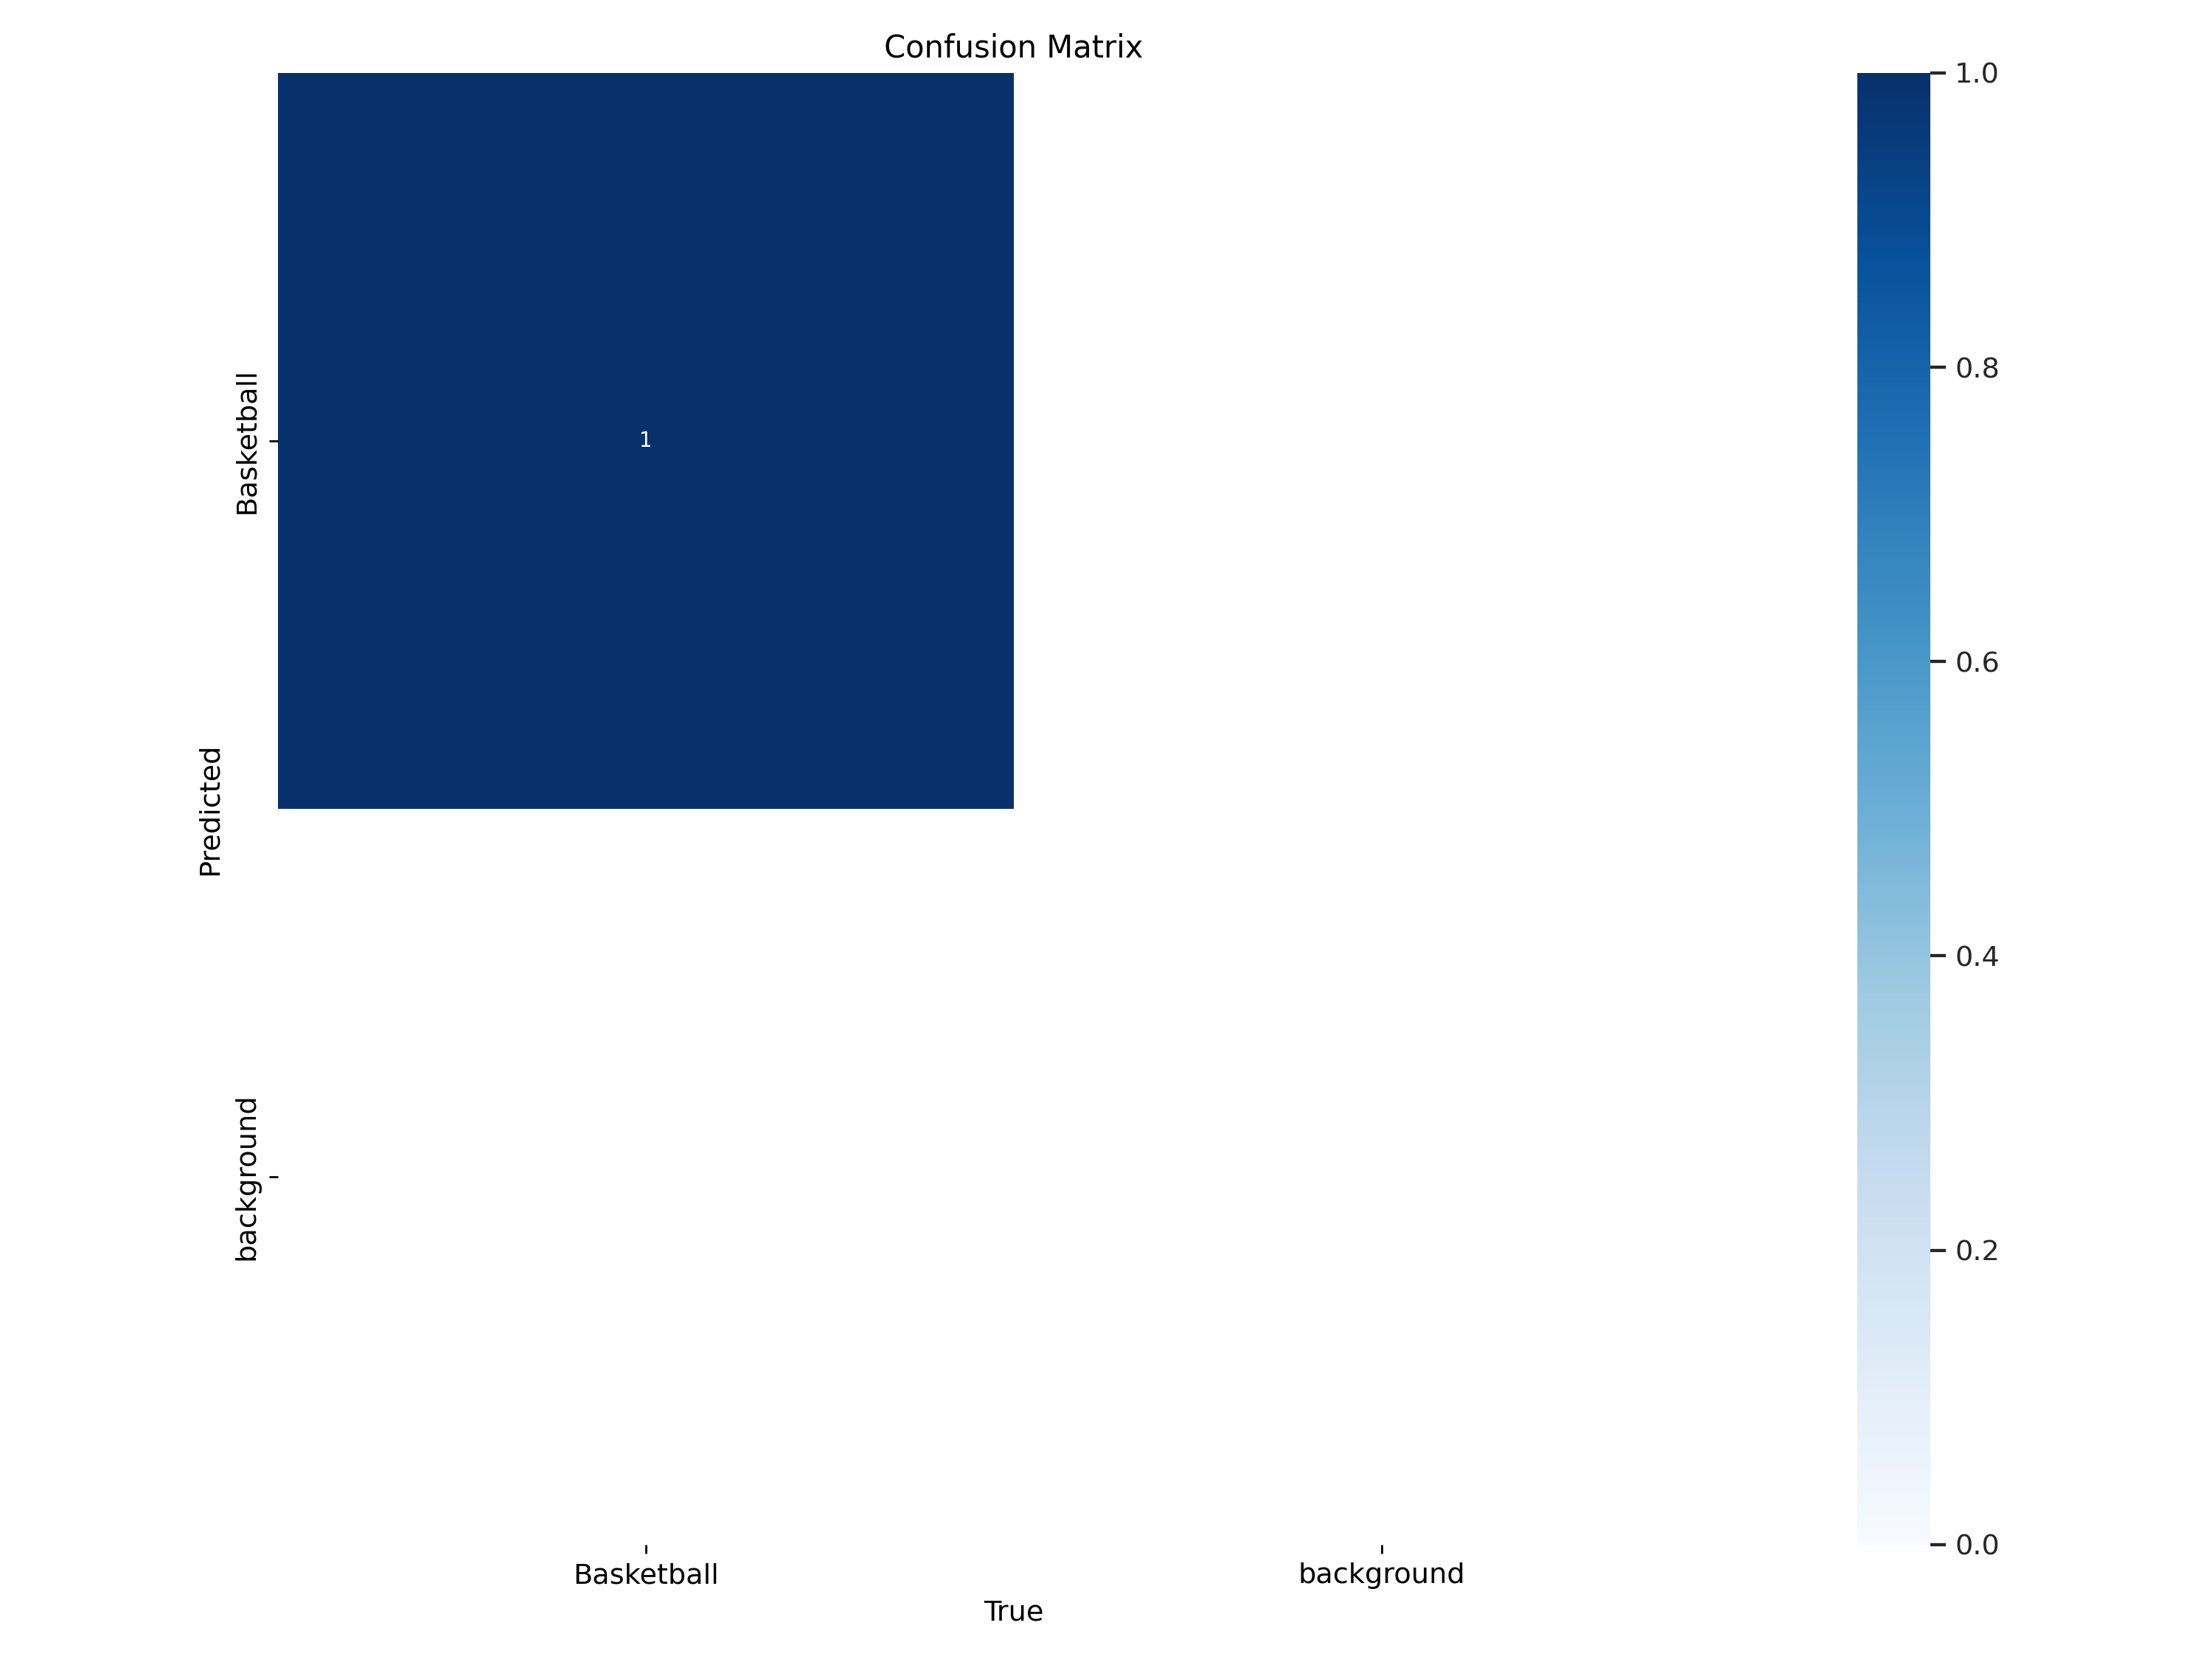

In [ ]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=600)

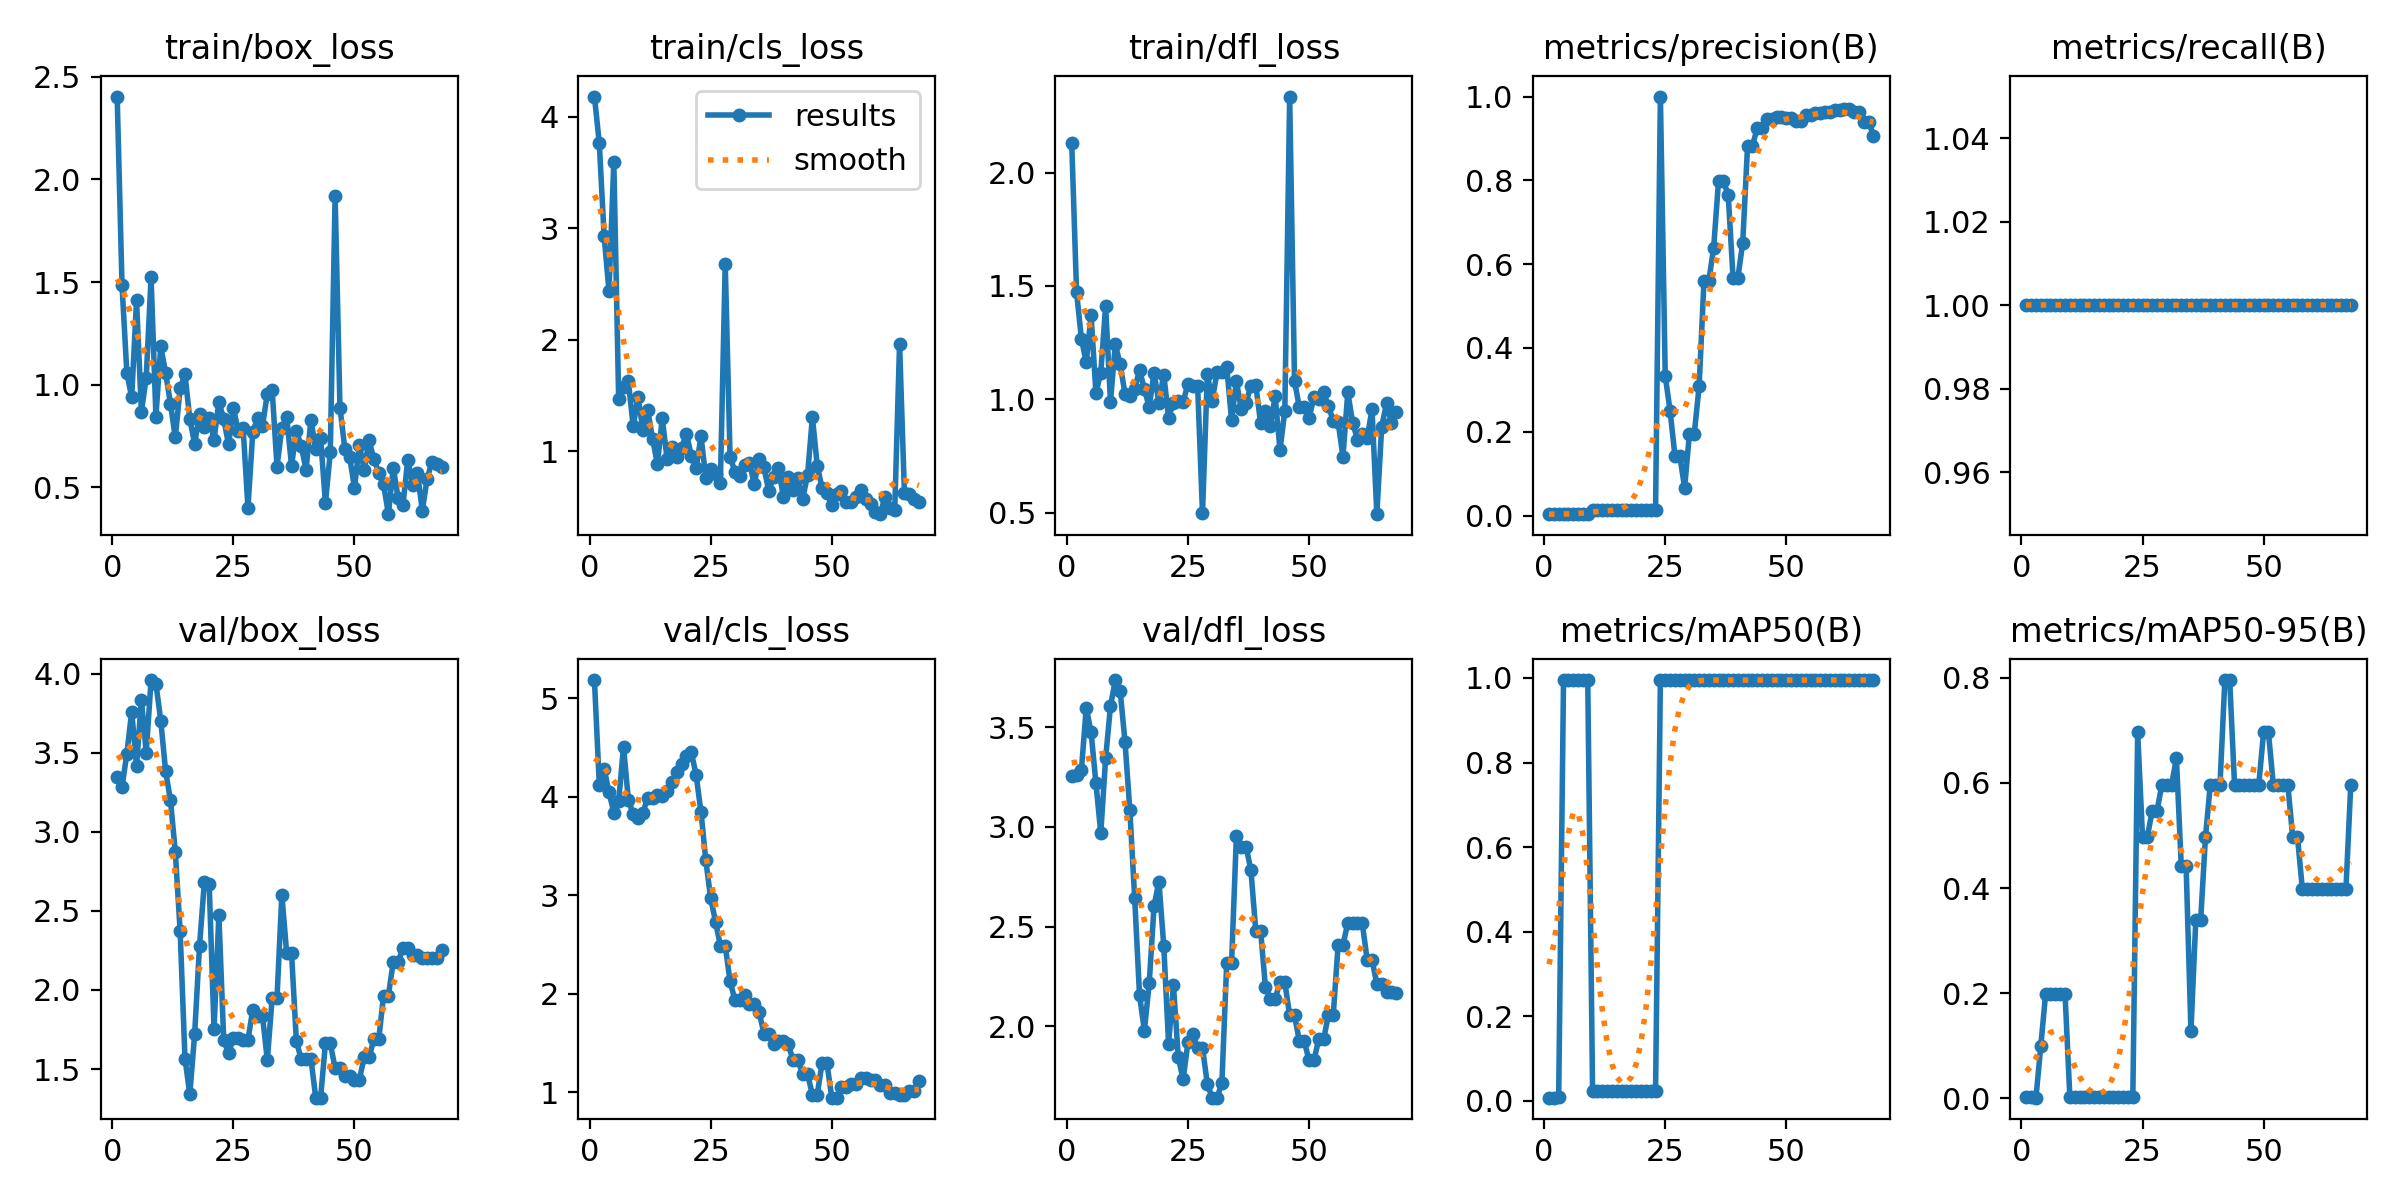

In [ ]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/results.png', width=600)

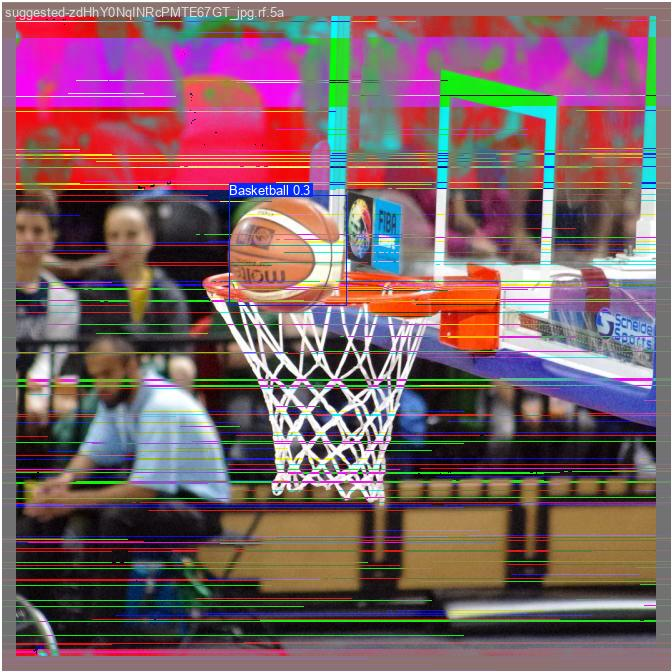

In [ ]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/val_batch0_pred.jpg', width=600)

In [ ]:
# !yolo task=detect mode=val model={HOME}/runs/detect/train/weights/best.pt data={dataset.location}/data.yaml

In [ ]:
# project.version(dataset.version).deploy(model_type="yolov11", model_path=f"{HOME}/runs/detect/train/")

Running inference on suggested-XWTvfDY1tLS473huZiKG_jpg.rf.e6aa4bff9f99c3b197c11a6d7d165961.jpg

0: 640x640 4 persons, 2 ties, 1 vase, 276.8ms
Speed: 7.9ms preprocess, 276.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


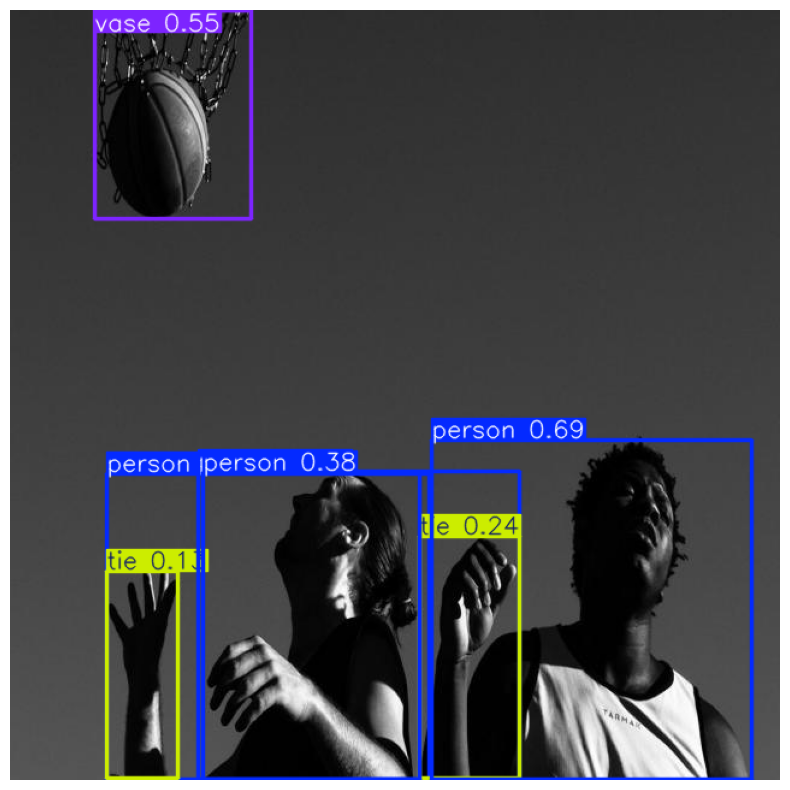

In [ ]:
import os, random, cv2
import supervision as sv
import IPython
import matplotlib.pyplot as plt

# Location of test set images
test_set_loc = '/content/datasets/Shot-Tracker-2/test/images'
test_images = os.listdir(test_set_loc)

# Run inference on 4 random test images, or fewer if fewer images are available
for img_name in random.sample(test_images, min(4, len(test_images))):
    # Load image
    image = cv2.imread(os.path.join(test_set_loc, img_name))
    if image is None:
      continue

    print("Running inference on " + img_name)

    # Perform inference
    results = model.predict(image, conf=0.1)
    annotatedImage = results[0].plot()

    # Display the image using Matplotlib
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(annotatedImage, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for proper display
    plt.axis("off")  # Hide axis for better visualization
    plt.show()

In [ ]:
# Load the YOLO11 model

# Export the model to TFLite format
model.export(format="torchscript")

# Load the exported TFLite model
# tflite_model = YOLO("yolo11n_float32.tflite")

# Run inference
# results = tflite_model("https://ultralytics.com/images/bus.jpg")

Ultralytics 8.3.40 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
YOLO11n summary (fused): 238 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs

PyTorch: starting from 'runs/detect/train/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5, 8400) (5.2 MB)

TorchScript: starting export with torch 2.6.0+cu124...
TorchScript: export success ✅ 3.6s, saved as 'runs/detect/train/weights/best.torchscript' (10.4 MB)

Export complete (4.4s)
Results saved to /content/runs/detect/train/weights
Predict:         yolo predict task=detect model=runs/detect/train/weights/best.torchscript imgsz=640  
Validate:        yolo val task=detect model=runs/detect/train/weights/best.torchscript imgsz=640 data=/content/datasets/Shot-Tracker-2/data.yaml  
Visualize:       https://netron.app


'runs/detect/train/weights/best.torchscript'